# Declaration of Originality

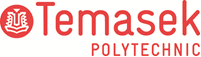

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Tan Wen Jun (2400845J)
* Tutorial Group                : C24B04
* Tutor						    : Mr. Emile Sabastian
* Submission Date               : 11/2/2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# 🌟 Stellar Object Classification — SDSS Dataset
## Sloan Digital Sky Survey: Classifying Stars, Galaxies & Quasars

**Dataset:** 100,000 astronomical observations  
**Task:** Multi-class Classification — STAR | GALAXY | QSO  
**Modelling library:** scikit-learn (only)  

---
## Section 1: Business Understanding

### What Problem Are We Solving?

Every night, the **Sloan Digital Sky Survey (SDSS)** records hundreds of thousands of new light sources across the sky. Each detection is described by its brightness across five photometric wavelength bands and its spectroscopic redshift. Before any scientific analysis can begin, astronomers must resolve a foundational question: **is this object a star, a galaxy, or a quasar?**

Historically, this classification was done manually by expert reviewers or through rigid, hand-crafted rule sets. These approaches cannot scale. The upcoming **Vera C. Rubin Observatory (LSST)** is projected to generate over 10 million transient alerts per night alone — a volume that makes human-driven classification operationally impossible.

### The Machine Learning Outcome

We build a **supervised multi-class classifier** that takes an SDSS observation's photometric and spectral measurements as input and outputs a predicted object class — STAR, GALAXY, or QSO. The model is trained on 80,000 labelled historical observations and validated on 20,000 held-out examples. The final trained model is exported and integrated into a live web application for real-time classification.

### Why Does This Matter to the Astronomy Community?

Accurate automated classification creates compounding value across the entire research pipeline:

**1. Cosmological mapping and dark energy research**  
Galaxies and quasars at precisely known redshifts are the tracers used to reconstruct the 3-D large-scale structure of the universe. Misclassifying galaxies degrades these maps, corrupting constraints on dark matter distributions, cosmic filaments, and the equation of state of dark energy. Every correct galaxy classification is a data point in humanity's understanding of why the universe's expansion is accelerating.

**2. Quasar science — preserving irreplaceable probes**  
Quasars are among the most energetic phenomena known — supermassive black holes actively consuming material at cosmological distances. Their light passes through billions of light-years of intergalactic gas, imprinting absorption signatures that reveal the composition, temperature, and structure of matter across cosmic time. A quasar misclassified as a star is silently discarded from these analyses. Our classifier must recall quasars with high sensitivity even though they are a minority class (~20% of observations).

**3. Stellar population and Milky Way structure studies**  
Studies of stellar chemistry, ages, and kinematics require a clean, uncontaminated stellar catalogue. Extragalactic objects leaking into stellar samples skew metallicity distributions and stellar age estimates. Precise star-galaxy separation is a prerequisite for any Milky Way structure analysis.

**4. Telescope time allocation**  
Spectroscopic follow-up — the expensive, time-limited step that yields precise redshifts and chemical abundances — is prioritised from photometric pre-classification. A high-precision classifier ensures that finite telescope hours are directed at the most scientifically valuable targets, not wasted confirming obvious objects or chasing misidentified ones.

**5. Foundation for next-generation surveys**  
A validated ML pipeline trained on SDSS establishes a transferable template for Euclid, DESI, and LSST — surveys that will collectively observe billions of objects. Algorithmic classification infrastructure built now directly enables the scientific output of the next decade of astronomy.

### Evaluation Metric Justification

We use **macro-averaged F1-score** as our primary metric. The dataset is moderately imbalanced (~59% galaxy, ~21% star, ~20% quasar). Raw accuracy would be dominated by galaxy performance — a classifier predicting "galaxy" for every observation achieves ~59% accuracy while completely failing on stars and quasars. Macro-F1 weights precision and recall **equally across all three classes**, directly reflecting the scientific requirement that no object type be systematically neglected. A high macro-F1 score means the model is reliably correct for stars, galaxies, and rare quasars alike.

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 1 — Global Imports & Reproducibility
#
# All modelling uses scikit-learn exclusively (no XGBoost, LightGBM, etc.).
# RANDOM_STATE = 42 seeds every stochastic step so results are fully
# reproducible: same split, same tree initialisation, same search order.
# ─────────────────────────────────────────────────────────────────────────────
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joblib
import json

# scikit-learn — ONLY library used for modelling
from sklearn.model_selection  import train_test_split, RandomizedSearchCV
from sklearn.preprocessing    import LabelEncoder, StandardScaler
from sklearn.ensemble         import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.pipeline         import Pipeline
from sklearn.metrics          import (classification_report, confusion_matrix,
                                       f1_score, accuracy_score, ConfusionMatrixDisplay)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('dark_background')
PALETTE = {'GALAXY': '#4FC3F7', 'STAR': '#FFD54F', 'QSO': '#EF9A9A'}

print(f'✅ Libraries loaded | RANDOM_STATE = {RANDOM_STATE}')

✅ Libraries loaded | RANDOM_STATE = 42


---
## Section 2: Data Understanding

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2a — Load Dataset
# ─────────────────────────────────────────────────────────────────────────────
df = pd.read_csv('star_classification.csv')
print(f'Shape: {df.shape}  ({df.shape[0]:,} rows × {df.shape[1]} columns)')
df.head()

Shape: (100000, 18)  (100,000 rows × 18 columns)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2b — Variable Types and Roles
#
# Each column is assigned a role:
#   IDENTIFIER  — observatory bookkeeping; no predictive value
#   POSITIONAL  — sky coordinates
#   PHOTOMETRIC — spectral measurements (our primary features)
#   TARGET      — class label to predict
#
# Annotating roles here guides feature dropping decisions in Section 4.
# ─────────────────────────────────────────────────────────────────────────────
role_map = {
    'obj_ID'     : 'Identifier  — unique object ID (arbitrary integer)',
    'alpha'      : 'Positional  — Right Ascension angle (J2000)',
    'delta'      : 'Positional  — Declination angle (J2000)',
    'u'          : 'Photometric — Ultraviolet filter magnitude',
    'g'          : 'Photometric — Green filter magnitude',
    'r'          : 'Photometric — Red filter magnitude',
    'i'          : 'Photometric — Near-Infrared filter magnitude',
    'z'          : 'Photometric — Infrared filter magnitude',
    'run_ID'     : 'Identifier  — scan run number',
    'rerun_ID'   : 'Identifier  — image reprocessing number',
    'cam_col'    : 'Identifier  — camera column within scan',
    'field_ID'   : 'Identifier  — field number within scan',
    'spec_obj_ID': 'Identifier  — ⚠️ LEAKAGE RISK: same ID = same class (per dataset spec)',
    'class'      : 'TARGET      — GALAXY / STAR / QSO',
    'redshift'   : 'Spectral    — redshift z (wavelength stretch proxy for distance)',
    'plate'      : 'Identifier  — spectroscopic plate ID',
    'MJD'        : 'Identifier  — Modified Julian Date of observation',
    'fiber_ID'   : 'Identifier  — fibre pointing to focal plane',
}
type_df = pd.DataFrame({'Column': df.columns, 'dtype': df.dtypes.values,
                         'Role': [role_map[c] for c in df.columns]})
print(type_df.to_string(index=False))

     Column   dtype                                                                   Role
     obj_ID float64                     Identifier  — unique object ID (arbitrary integer)
      alpha float64                            Positional  — Right Ascension angle (J2000)
      delta float64                                Positional  — Declination angle (J2000)
          u float64                             Photometric — Ultraviolet filter magnitude
          g float64                                   Photometric — Green filter magnitude
          r float64                                     Photometric — Red filter magnitude
          i float64                           Photometric — Near-Infrared filter magnitude
          z float64                                Photometric — Infrared filter magnitude
     run_ID   int64                                          Identifier  — scan run number
   rerun_ID   int64                                Identifier  — image reprocessing number

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2c — Missing Data Check
#
# Normal astronomical outliers won't be removed as they are real phenomena (e.g. quasars with extreme colours). 
# ─────────────────────────────────────────────────────────────────────────────
print(df.isnull().sum())
missing = df.isnull().sum()
if missing.sum() == 0:
    print('✅ No missing values in any column.')
else:
    print(missing[missing > 0])

# ── Check for sentinel values (-9999 meaning "measurement failed")
# SDSS uses -9999 as a sentinel for missing/failed photometric measurements.
# These are NOT NaN so isnull() misses them.
print('\nSentinel value check (values < -100 = failed measurement):')
sentinel_found = False
for col in ['u', 'g', 'r', 'i', 'z']:
    n = (df[col] < -100).sum()
    if n > 0:
        print(f'  {col}: {n} sentinel values ({df[col].min():.0f})')
        sentinel_found = True
if not sentinel_found:
    print('  None found.')
else:
    print('\n⚠️  IMPLICATION: These rows will be removed in data preparation.')
    print('  Sentinel values would corrupt feature engineering (colour indices)')
    print('  and act as extreme outliers that mislead the model.')

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64
✅ No missing values in any column.

Sentinel value check (values < -100 = failed measurement):
  u: 1 sentinel values (-9999)
  g: 1 sentinel values (-9999)
  z: 1 sentinel values (-9999)

⚠️  IMPLICATION: These rows will be removed in data preparation.
  Sentinel values would corrupt feature engineering (colour indices)
  and act as extreme outliers that mislead the model.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2d — Statistical Summary
#
# Note that the identifier columns are excluded here as they hold no numeric value.
# ─────────────────────────────────────────────────────────────────────────────
print('Statistical summary:')
df.describe().drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID',
                            'spec_obj_ID', 'plate', 'MJD', 'fiber_ID']).T

Statistical summary:


,count,mean,std,min,25%,50%,75%,max
alpha,100000.0,177.629117,96.502241,0.005528,127.518222,180.900700,233.895005,359.999810
delta,100000.0,24.135305,19.644665,-18.785328,5.146771,23.645922,39.901550,83.000519
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.781390
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.602240
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.571860
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.141470
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.383740
redshift,100000.0,0.576661,0.730707,-0.009971,0.054517,0.424173,0.704154,7.011245


---
## Section 3: Exploratory Data Analysis (EDA)

---
## Section 4: Data Preparation

---
## Section 5: Modelling

---
## Section 6: Model Evaluation

---
## Section 7: Iterative Development — Feature Engineering, Selection & Tuning